# Train SSD with SubT datasets

# Clone SSD Function

In [ ]:
!git clone https://github.com/ARG-NCTU/ssd.pytorch.git

Cloning into 'ssd.pytorch'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1486 (delta 5), reused 10 (delta 3), pack-reused 1463
Receiving objects: 100% (1486/1486), 177.00 MiB | 39.03 MiB/s, done.
Resolving deltas: 100% (880/880), done.


In [ ]:
import sys
sys.path.append('/content/ssd.pytorch')

# Import Libraries


In [ ]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import matplotlib.pyplot as plt
import torchvision
import random
import os.path as osp

# Download Datasets

In [ ]:
import logging
import gdown
from zipfile import ZipFile
dataset_url = 'https://drive.google.com/u/1/uc?id=1qw5tEMkUBbpprNpqcBfbAJy1UbJSyAm6'
dataset_name = 'SSD'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
    zip1 = ZipFile(dataset_name + '.zip')
    zip1.extractall(dataset_name)
    zip1.close()


print("Finished downloading dataset.")

Downloading...
From: https://drive.google.com/u/1/uc?id=1qw5tEMkUBbpprNpqcBfbAJy1UbJSyAm6
To: /content/SSD.zip
27.7MB [00:00, 48.1MB/s]

Finished downloading dataset.


# Argument Declare

In [ ]:
DATASET_ROOT = "/content/SSD/SSD-datasets"
DATASET_NAME = "/SSD"
cfg = SubT
BASE_NET = "/content/ssd.pytorch/weight/vgg16_reducedfc.pth"
DATA_DETECTION = SUBTDetection
BATCH_SIZE = 10
PRETRAINED_MODEL = None
PRETRAINED_ITER = 0
SAVE_MODEL_ITER = 500
START_ITER = 0
NUM_WORKERS = 4
CUDA = True
LR = 1e-3
MOMENTUM = 0.4
WEIGHT_DECAY = 5e-4
GAMMA = 0.1
VISDOM = False
SAVE_FOLDER = "/content/ssd.pytorch/weight/" + DATASET_NAME +"/"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print('done')
print(DATA_DETECTION)

done
data.subt_artifact.SUBTDetection


In [ ]:
if torch.cuda.is_available():
    if not CUDA:
        print("WTF are u wasting your CUDA device?")
    else:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# Define function

In [ ]:
def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

# Initial model weights & bias
def xavier(param):
    init.xavier_uniform(param)
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

# Adjust learning rate during training
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = LR * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        print("Change learning rate to: ", lr)

# Create dataset

In [ ]:
dataset = DATA_DETECTION(root=DATASET_ROOT, image_sets=['train'],transform=SSDAugmentation(cfg['min_dim'], MEANS))

classes = dataset.target_transform.class_to_ind
print(classes)
print("Class to index: \n", classes)
classes = sorted(classes.items(), key=lambda kv: kv[1])
label = []
for i in classes:
    label.append(i[0])
label.append('None')
print(label)
true_label = ['boat']
print(dataset.target_transform)

{'boat': 0}
Class to index: 
 {'boat': 0}
['boat', 'None']


# Create model

In [ ]:
# Delcare SSD Network
ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
# ssd_net = build_ssd('train', cfg['min_dim'], 6)
net = ssd_net
if CUDA:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True
    
if PRETRAINED_MODEL is not None: # Use SSD pretrained model
    print('Resuming training, loading {}...'.format(PRETRAINED_MODEL))
    ssd_net.load_weights(SAVE_FOLDER + PRETRAINED_MODEL)
else:
    print('Initializing weights...')
    vgg_weights = torch.load(BASE_NET) # load vgg pretrained model
    ssd_net.vgg.load_state_dict(vgg_weights)
    ssd_net.extras.apply(weights_init) # Initial SSD model weights & bias
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM,
                weight_decay=WEIGHT_DECAY)
print(cfg['min_dim'])
criterion = MultiBoxLoss(BATCH_SIZE ,cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,False, CUDA)

Initializing weights...
300


/content/ssd.pytorch/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


# Training

Initialize

In [ ]:
net.train()
# loss counters
loc_loss = 0
conf_loss = 0
epoch = 0
print('Loading the dataset...')
epoch_size = len(dataset) // BATCH_SIZE
print('Training SSD on:', DATASET_NAME)

data_loader = data.DataLoader(dataset, BATCH_SIZE,
                num_workers=NUM_WORKERS,
                shuffle=True, collate_fn=detection_collate,
                pin_memory=True)
batch_iterator = iter(data_loader)

Loading the dataset...
Training SSD on: /SSD


Start training

In [ ]:
step_index = 0
for iteration in range(START_ITER, cfg['max_iter']):
    if iteration in cfg['lr_steps']:
        step_index += 1
        adjust_learning_rate(optimizer, GAMMA, step_index)
    
    # make sure data iter not out of range
    try:
        images, targets = next(batch_iterator)
        #print(targets[0][0][4].item(), label[int(targets[0][0][4].item())])
    except StopIteration:
        batch_iterator = iter(data_loader)
        images, targets = next(batch_iterator)
    if CUDA:
        images = Variable(images.cuda())
        targets = [Variable(ann.cuda(), volatile=True) for ann in targets]
    else:
        images = Variable(images)
        targets = [Variable(ann, volatile=True) for ann in targets]
    
    # Forward
    t0 = time.time()
    out = net(images)
    # backprop
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    loss.backward()
    optimizer.step()
    t1 = time.time()
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
    
    if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(PRETRAINED_ITER + iteration) + ' || Loss: %.4f ||' % (loss.item()), end='')
    
    if iteration != 0 and iteration % SAVE_MODEL_ITER == 0:
            print('Saving state, iter:', iteration)
            torch.save(ssd_net.state_dict(), SAVE_FOLDER + DATASET_NAME + "_" +
                       repr(PRETRAINED_ITER + iteration) + '.pth')
# Save final model
torch.save(ssd_net.state_dict(),
            SAVE_FOLDER + DATASET_NAME + '.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 4.8261 sec.
iter 0 || Loss: 25.4106 ||timer: 0.1562 sec.
iter 10 || Loss: 10.7786 ||timer: 0.1442 sec.
iter 20 || Loss: 10.4757 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1984 sec.
iter 30 || Loss: 10.4403 ||timer: 0.1717 sec.
iter 40 || Loss: 9.7376 ||timer: 0.1496 sec.
iter 50 || Loss: 9.8508 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1737 sec.
iter 60 || Loss: 9.2321 ||timer: 0.1635 sec.
iter 70 || Loss: 7.4653 ||timer: 0.1510 sec.
iter 80 || Loss: 6.3486 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1623 sec.
iter 90 || Loss: 5.4161 ||timer: 0.1586 sec.
iter 100 || Loss: 5.5862 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2002 sec.
iter 110 || Loss: 5.6576 ||timer: 0.1655 sec.
iter 120 || Loss: 4.7019 ||timer: 0.1469 sec.
iter 130 || Loss: 4.3716 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1639 sec.
iter 140 || Loss: 3.3231 ||timer: 0.1597 sec.
iter 150 || Loss: 4.3370 ||timer: 0.1465 sec.
iter 160 || Loss: 3.9781 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1606 sec.
iter 170 || Loss: 4.1378 ||timer: 0.1560 sec.
iter 180 || Loss: 4.0937 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2146 sec.
iter 190 || Loss: 4.4828 ||timer: 0.1684 sec.
iter 200 || Loss: 2.5999 ||timer: 0.1472 sec.
iter 210 || Loss: 3.4032 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1784 sec.
iter 220 || Loss: 3.1704 ||timer: 0.1564 sec.
iter 230 || Loss: 2.8200 ||timer: 0.1467 sec.
iter 240 || Loss: 2.9807 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1658 sec.
iter 250 || Loss: 2.8400 ||timer: 0.1730 sec.
iter 260 || Loss: 2.8172 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2342 sec.
iter 270 || Loss: 2.5745 ||timer: 0.1578 sec.
iter 280 || Loss: 2.6282 ||timer: 0.1483 sec.
iter 290 || Loss: 2.1857 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2011 sec.
iter 300 || Loss: 2.8463 ||timer: 0.1559 sec.
iter 310 || Loss: 2.4097 ||timer: 0.1523 sec.
iter 320 || Loss: 1.9351 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2152 sec.
iter 330 || Loss: 3.1473 ||timer: 0.1592 sec.
iter 340 || Loss: 2.6007 ||timer: 0.1464 sec.
iter 350 || Loss: 2.8083 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1659 sec.
iter 360 || Loss: 2.0699 ||timer: 0.1572 sec.
iter 370 || Loss: 2.3937 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1985 sec.
iter 380 || Loss: 2.3831 ||timer: 0.1639 sec.
iter 390 || Loss: 2.1504 ||timer: 0.1458 sec.
iter 400 || Loss: 2.1671 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1931 sec.
iter 410 || Loss: 2.3551 ||timer: 0.1571 sec.
iter 420 || Loss: 2.3835 ||timer: 0.1476 sec.
iter 430 || Loss: 2.0889 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1584 sec.
iter 440 || Loss: 2.8222 ||timer: 0.1556 sec.
iter 450 || Loss: 2.5025 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1944 sec.
iter 460 || Loss: 2.4941 ||timer: 0.1581 sec.
iter 470 || Loss: 3.1739 ||timer: 0.1455 sec.
iter 480 || Loss: 2.3828 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2147 sec.
iter 490 || Loss: 2.1037 ||timer: 0.1573 sec.
iter 500 || Loss: 1.9090 ||Saving state, iter: 500
timer: 0.1523 sec.
iter 510 || Loss: 2.2555 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1561 sec.
iter 520 || Loss: 1.9488 ||timer: 0.1703 sec.
iter 530 || Loss: 1.8343 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2334 sec.
iter 540 || Loss: 2.1230 ||timer: 0.1599 sec.
iter 550 || Loss: 2.2984 ||timer: 0.1470 sec.
iter 560 || Loss: 1.8892 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1903 sec.
iter 570 || Loss: 3.0457 ||timer: 0.1671 sec.
iter 580 || Loss: 1.6776 ||timer: 0.1465 sec.
iter 590 || Loss: 2.3617 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1761 sec.
iter 600 || Loss: 2.2331 ||timer: 0.1552 sec.
iter 610 || Loss: 2.5478 ||timer: 0.1455 sec.
iter 620 || Loss: 1.6273 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1683 sec.
iter 630 || Loss: 1.3021 ||timer: 0.1574 sec.
iter 640 || Loss: 1.9491 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1951 sec.
iter 650 || Loss: 1.6721 ||timer: 0.1677 sec.
iter 660 || Loss: 1.6892 ||timer: 0.1470 sec.
iter 670 || Loss: 1.8084 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1615 sec.
iter 680 || Loss: 1.6956 ||timer: 0.1594 sec.
iter 690 || Loss: 1.3444 ||timer: 0.1468 sec.
iter 700 || Loss: 1.6556 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1624 sec.
iter 710 || Loss: 1.4141 ||timer: 0.1670 sec.
iter 720 || Loss: 1.6318 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1983 sec.
iter 730 || Loss: 1.6223 ||timer: 0.1895 sec.
iter 740 || Loss: 1.7007 ||timer: 0.1457 sec.
iter 750 || Loss: 1.5199 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2026 sec.
iter 760 || Loss: 1.4166 ||timer: 0.1704 sec.
iter 770 || Loss: 1.7827 ||timer: 0.1495 sec.
iter 780 || Loss: 1.5374 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1678 sec.
iter 790 || Loss: 1.7018 ||timer: 0.1662 sec.
iter 800 || Loss: 1.3916 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2206 sec.
iter 810 || Loss: 1.4573 ||timer: 0.1714 sec.
iter 820 || Loss: 1.3546 ||timer: 0.1489 sec.
iter 830 || Loss: 1.4741 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2139 sec.
iter 840 || Loss: 1.8209 ||timer: 0.1601 sec.
iter 850 || Loss: 1.5600 ||timer: 0.1468 sec.
iter 860 || Loss: 1.5965 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1733 sec.
iter 870 || Loss: 1.3165 ||timer: 0.1625 sec.
iter 880 || Loss: 2.5178 ||timer: 0.1473 sec.
iter 890 || Loss: 1.9018 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1658 sec.
iter 900 || Loss: 1.2877 ||timer: 0.1529 sec.
iter 910 || Loss: 1.7507 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2342 sec.
iter 920 || Loss: 1.8873 ||timer: 0.1677 sec.
iter 930 || Loss: 2.3223 ||timer: 0.1477 sec.
iter 940 || Loss: 1.5897 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1801 sec.
iter 950 || Loss: 1.7109 ||timer: 0.1665 sec.
iter 960 || Loss: 2.0210 ||timer: 0.1456 sec.
iter 970 || Loss: 1.3092 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1608 sec.
iter 980 || Loss: 1.9120 ||timer: 0.1713 sec.
iter 990 || Loss: 1.7875 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2085 sec.
iter 1000 || Loss: 2.2024 ||Saving state, iter: 1000
timer: 0.1669 sec.
iter 1010 || Loss: 1.2310 ||timer: 0.1463 sec.
iter 1020 || Loss: 1.4661 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2158 sec.
iter 1030 || Loss: 1.6821 ||timer: 0.1856 sec.
iter 1040 || Loss: 1.7486 ||timer: 0.1478 sec.
iter 1050 || Loss: 1.4853 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1891 sec.
iter 1060 || Loss: 1.3209 ||timer: 0.1629 sec.
iter 1070 || Loss: 1.8581 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2243 sec.
iter 1080 || Loss: 1.6456 ||timer: 0.1818 sec.
iter 1090 || Loss: 1.6693 ||timer: 0.1462 sec.
iter 1100 || Loss: 1.5652 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2240 sec.
iter 1110 || Loss: 1.3030 ||timer: 0.1640 sec.
iter 1120 || Loss: 1.2797 ||timer: 0.1488 sec.
iter 1130 || Loss: 2.4516 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1681 sec.
iter 1140 || Loss: 1.4468 ||timer: 0.1573 sec.
iter 1150 || Loss: 1.4383 ||timer: 0.1453 sec.
iter 1160 || Loss: 1.2813 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1613 sec.
iter 1170 || Loss: 1.1134 ||timer: 0.1460 sec.
iter 1180 || Loss: 1.4984 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2147 sec.
iter 1190 || Loss: 1.3452 ||timer: 0.1707 sec.
iter 1200 || Loss: 1.6542 ||timer: 0.1467 sec.
iter 1210 || Loss: 1.5927 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1754 sec.
iter 1220 || Loss: 1.7640 ||timer: 0.1715 sec.
iter 1230 || Loss: 1.1831 ||timer: 0.1473 sec.
iter 1240 || Loss: 1.4922 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1717 sec.
iter 1250 || Loss: 1.2082 ||timer: 0.1814 sec.
iter 1260 || Loss: 1.4445 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2175 sec.
iter 1270 || Loss: 1.4162 ||timer: 0.2027 sec.
iter 1280 || Loss: 1.8237 ||timer: 0.1469 sec.
iter 1290 || Loss: 1.2583 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2213 sec.
iter 1300 || Loss: 1.7018 ||timer: 0.1548 sec.
iter 1310 || Loss: 1.1239 ||timer: 0.1473 sec.
iter 1320 || Loss: 1.7419 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1548 sec.
iter 1330 || Loss: 1.0826 ||timer: 0.1689 sec.
iter 1340 || Loss: 1.2625 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2097 sec.
iter 1350 || Loss: 1.3399 ||timer: 0.1824 sec.
iter 1360 || Loss: 1.4756 ||timer: 0.1449 sec.
iter 1370 || Loss: 1.2536 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1787 sec.
iter 1380 || Loss: 1.4958 ||timer: 0.1687 sec.
iter 1390 || Loss: 1.5298 ||timer: 0.1448 sec.
iter 1400 || Loss: 1.9976 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1841 sec.
iter 1410 || Loss: 1.6160 ||timer: 0.1577 sec.
iter 1420 || Loss: 1.2992 ||timer: 0.1451 sec.
iter 1430 || Loss: 1.1776 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1608 sec.
iter 1440 || Loss: 1.5366 ||timer: 0.1673 sec.
iter 1450 || Loss: 1.2543 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1905 sec.
iter 1460 || Loss: 1.6530 ||timer: 0.1764 sec.
iter 1470 || Loss: 1.3630 ||timer: 0.1482 sec.
iter 1480 || Loss: 1.6001 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2163 sec.
iter 1490 || Loss: 1.1794 ||timer: 0.1566 sec.
iter 1500 || Loss: 1.1361 ||Saving state, iter: 1500
timer: 0.1493 sec.
iter 1510 || Loss: 1.1454 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1606 sec.
iter 1520 || Loss: 1.4025 ||timer: 0.1679 sec.
iter 1530 || Loss: 1.1639 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2093 sec.
iter 1540 || Loss: 1.2152 ||timer: 0.1590 sec.
iter 1550 || Loss: 1.7266 ||timer: 0.1480 sec.
iter 1560 || Loss: 1.1143 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2218 sec.
iter 1570 || Loss: 1.0458 ||timer: 0.1577 sec.
iter 1580 || Loss: 1.4394 ||timer: 0.1455 sec.
iter 1590 || Loss: 1.5525 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1613 sec.
iter 1600 || Loss: 1.5203 ||timer: 0.1555 sec.
iter 1610 || Loss: 1.4386 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2235 sec.
iter 1620 || Loss: 1.3220 ||timer: 0.1577 sec.
iter 1630 || Loss: 1.0993 ||timer: 0.1469 sec.
iter 1640 || Loss: 1.1149 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1963 sec.
iter 1650 || Loss: 1.1025 ||timer: 0.1550 sec.
iter 1660 || Loss: 1.2853 ||timer: 0.1445 sec.
iter 1670 || Loss: 1.1248 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1766 sec.
iter 1680 || Loss: 1.9356 ||timer: 0.1573 sec.
iter 1690 || Loss: 0.8516 ||timer: 0.1482 sec.
iter 1700 || Loss: 1.0792 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1664 sec.
iter 1710 || Loss: 1.0237 ||timer: 0.1552 sec.
iter 1720 || Loss: 1.3095 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2268 sec.
iter 1730 || Loss: 0.9973 ||timer: 0.1606 sec.
iter 1740 || Loss: 1.2549 ||timer: 0.1487 sec.
iter 1750 || Loss: 1.1478 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2447 sec.
iter 1760 || Loss: 1.3848 ||timer: 0.1656 sec.
iter 1770 || Loss: 1.5396 ||timer: 0.1460 sec.
iter 1780 || Loss: 1.3389 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1567 sec.
iter 1790 || Loss: 1.2410 ||timer: 0.1921 sec.
iter 1800 || Loss: 1.2202 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2025 sec.
iter 1810 || Loss: 0.9191 ||timer: 0.1567 sec.
iter 1820 || Loss: 1.2146 ||timer: 0.1467 sec.
iter 1830 || Loss: 1.0731 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1989 sec.
iter 1840 || Loss: 0.8976 ||timer: 0.1600 sec.
iter 1850 || Loss: 1.0863 ||timer: 0.1465 sec.
iter 1860 || Loss: 0.9939 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1690 sec.
iter 1870 || Loss: 1.0921 ||timer: 0.1652 sec.
iter 1880 || Loss: 1.3256 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2317 sec.
iter 1890 || Loss: 1.1767 ||timer: 0.1653 sec.
iter 1900 || Loss: 1.3632 ||timer: 0.1466 sec.
iter 1910 || Loss: 1.3631 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2051 sec.
iter 1920 || Loss: 1.6505 ||timer: 0.1722 sec.
iter 1930 || Loss: 0.9226 ||timer: 0.1469 sec.
iter 1940 || Loss: 0.9858 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1688 sec.
iter 1950 || Loss: 0.8944 ||timer: 0.1566 sec.
iter 1960 || Loss: 0.8023 ||timer: 0.1475 sec.
iter 1970 || Loss: 1.1864 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1563 sec.
iter 1980 || Loss: 1.0402 ||timer: 0.1463 sec.
iter 1990 || Loss: 1.5076 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1801 sec.
iter 2000 || Loss: 0.9374 ||Saving state, iter: 2000
timer: 0.1662 sec.
iter 2010 || Loss: 0.8854 ||timer: 0.1466 sec.
iter 2020 || Loss: 0.9994 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1810 sec.
iter 2030 || Loss: 1.1189 ||timer: 0.1648 sec.
iter 2040 || Loss: 1.8823 ||timer: 0.1477 sec.
iter 2050 || Loss: 1.0151 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1562 sec.
iter 2060 || Loss: 1.1357 ||timer: 0.1629 sec.
iter 2070 || Loss: 1.1326 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2196 sec.
iter 2080 || Loss: 1.2073 ||timer: 0.1558 sec.
iter 2090 || Loss: 1.0243 ||timer: 0.1469 sec.
iter 2100 || Loss: 1.7066 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1966 sec.
iter 2110 || Loss: 1.1685 ||timer: 0.1730 sec.
iter 2120 || Loss: 1.1803 ||timer: 0.1465 sec.
iter 2130 || Loss: 1.1964 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1582 sec.
iter 2140 || Loss: 1.7535 ||timer: 0.1676 sec.
iter 2150 || Loss: 1.3138 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2574 sec.
iter 2160 || Loss: 1.1430 ||timer: 0.1737 sec.
iter 2170 || Loss: 0.9294 ||timer: 0.1520 sec.
iter 2180 || Loss: 1.1821 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2592 sec.
iter 2190 || Loss: 1.5317 ||timer: 0.1566 sec.
iter 2200 || Loss: 1.2147 ||timer: 0.1464 sec.
iter 2210 || Loss: 1.2337 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1938 sec.
iter 2220 || Loss: 0.9981 ||timer: 0.1677 sec.
iter 2230 || Loss: 1.2365 ||timer: 0.1446 sec.
iter 2240 || Loss: 1.0321 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1908 sec.
iter 2250 || Loss: 0.9253 ||timer: 0.1463 sec.
iter 2260 || Loss: 1.4671 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2009 sec.
iter 2270 || Loss: 1.3391 ||timer: 0.1558 sec.
iter 2280 || Loss: 1.1198 ||timer: 0.1461 sec.
iter 2290 || Loss: 1.4002 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1877 sec.
iter 2300 || Loss: 1.2511 ||timer: 0.1728 sec.
iter 2310 || Loss: 1.7895 ||timer: 0.1457 sec.
iter 2320 || Loss: 1.4836 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1652 sec.
iter 2330 || Loss: 0.8214 ||timer: 0.1803 sec.
iter 2340 || Loss: 1.4651 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2043 sec.
iter 2350 || Loss: 1.1330 ||timer: 0.1648 sec.
iter 2360 || Loss: 1.4246 ||timer: 0.1464 sec.
iter 2370 || Loss: 1.0745 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1965 sec.
iter 2380 || Loss: 1.0325 ||timer: 0.1624 sec.
iter 2390 || Loss: 1.4858 ||timer: 0.1508 sec.
iter 2400 || Loss: 1.0851 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1677 sec.
iter 2410 || Loss: 1.0713 ||timer: 0.1562 sec.
iter 2420 || Loss: 0.8690 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2016 sec.
iter 2430 || Loss: 0.9656 ||timer: 0.1545 sec.
iter 2440 || Loss: 1.0188 ||timer: 0.1474 sec.
iter 2450 || Loss: 0.8314 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2174 sec.
iter 2460 || Loss: 1.5127 ||timer: 0.1606 sec.
iter 2470 || Loss: 0.9580 ||timer: 0.1457 sec.
iter 2480 || Loss: 1.0831 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1829 sec.
iter 2490 || Loss: 0.7709 ||timer: 0.1559 sec.
iter 2500 || Loss: 1.2594 ||Saving state, iter: 2500
timer: 0.1489 sec.
iter 2510 || Loss: 0.9580 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1606 sec.
iter 2520 || Loss: 1.1117 ||timer: 0.1589 sec.
iter 2530 || Loss: 1.0011 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2344 sec.
iter 2540 || Loss: 1.2432 ||timer: 0.1732 sec.
iter 2550 || Loss: 1.5483 ||timer: 0.1461 sec.
iter 2560 || Loss: 1.3554 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2041 sec.
iter 2570 || Loss: 1.0000 ||timer: 0.1668 sec.
iter 2580 || Loss: 0.8732 ||timer: 0.1473 sec.
iter 2590 || Loss: 0.9301 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1587 sec.
iter 2600 || Loss: 0.9725 ||timer: 0.1588 sec.
iter 2610 || Loss: 1.1069 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2188 sec.
iter 2620 || Loss: 1.0957 ||timer: 0.1759 sec.
iter 2630 || Loss: 1.1643 ||timer: 0.1459 sec.
iter 2640 || Loss: 1.3141 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1785 sec.
iter 2650 || Loss: 1.1498 ||timer: 0.1590 sec.
iter 2660 || Loss: 1.2423 ||timer: 0.1464 sec.
iter 2670 || Loss: 0.9427 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1585 sec.
iter 2680 || Loss: 1.4253 ||timer: 0.1660 sec.
iter 2690 || Loss: 0.8922 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2287 sec.
iter 2700 || Loss: 1.3972 ||timer: 0.1779 sec.
iter 2710 || Loss: 1.3275 ||timer: 0.1468 sec.
iter 2720 || Loss: 1.1823 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1987 sec.
iter 2730 || Loss: 0.8681 ||timer: 0.1617 sec.
iter 2740 || Loss: 1.0992 ||timer: 0.1478 sec.
iter 2750 || Loss: 1.1310 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1737 sec.
iter 2760 || Loss: 1.5643 ||timer: 0.1554 sec.
iter 2770 || Loss: 1.0163 ||timer: 0.1494 sec.
iter 2780 || Loss: 1.3347 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1573 sec.
iter 2790 || Loss: 1.5035 ||timer: 0.1558 sec.
iter 2800 || Loss: 1.0727 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1979 sec.
iter 2810 || Loss: 1.6333 ||timer: 0.1889 sec.
iter 2820 || Loss: 0.5781 ||timer: 0.1444 sec.
iter 2830 || Loss: 1.2006 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1913 sec.
iter 2840 || Loss: 0.8749 ||timer: 0.1694 sec.
iter 2850 || Loss: 0.9458 ||timer: 0.1464 sec.
iter 2860 || Loss: 1.0247 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1753 sec.
iter 2870 || Loss: 0.8983 ||timer: 0.1648 sec.
iter 2880 || Loss: 0.9924 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2058 sec.
iter 2890 || Loss: 1.0482 ||timer: 0.1623 sec.
iter 2900 || Loss: 1.1051 ||timer: 0.1467 sec.
iter 2910 || Loss: 0.9072 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1949 sec.
iter 2920 || Loss: 0.8763 ||timer: 0.1671 sec.
iter 2930 || Loss: 0.9842 ||timer: 0.1455 sec.
iter 2940 || Loss: 0.8795 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1573 sec.
iter 2950 || Loss: 0.9632 ||timer: 0.1589 sec.
iter 2960 || Loss: 1.0583 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2464 sec.
iter 2970 || Loss: 0.8323 ||timer: 0.1582 sec.
iter 2980 || Loss: 1.2219 ||timer: 0.1463 sec.
iter 2990 || Loss: 1.3094 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1848 sec.
iter 3000 || Loss: 0.9891 ||Saving state, iter: 3000
timer: 0.1888 sec.
iter 3010 || Loss: 1.3256 ||timer: 0.1465 sec.
iter 3020 || Loss: 1.0538 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1812 sec.
iter 3030 || Loss: 1.1178 ||timer: 0.1662 sec.
iter 3040 || Loss: 0.7989 ||timer: 0.1461 sec.
iter 3050 || Loss: 1.0483 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1755 sec.
iter 3060 || Loss: 1.2756 ||timer: 0.1650 sec.
iter 3070 || Loss: 1.3114 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1992 sec.
iter 3080 || Loss: 1.2447 ||timer: 0.1651 sec.
iter 3090 || Loss: 1.5015 ||timer: 0.1525 sec.
iter 3100 || Loss: 1.1174 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2159 sec.
iter 3110 || Loss: 0.7807 ||timer: 0.1575 sec.
iter 3120 || Loss: 0.9678 ||timer: 0.1461 sec.
iter 3130 || Loss: 1.1445 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1627 sec.
iter 3140 || Loss: 1.1771 ||timer: 0.1685 sec.
iter 3150 || Loss: 1.0056 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1930 sec.
iter 3160 || Loss: 1.1339 ||timer: 0.1738 sec.
iter 3170 || Loss: 1.0125 ||timer: 0.1452 sec.
iter 3180 || Loss: 0.8844 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1994 sec.
iter 3190 || Loss: 0.8667 ||timer: 0.1573 sec.
iter 3200 || Loss: 0.9482 ||timer: 0.1458 sec.
iter 3210 || Loss: 0.8204 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2132 sec.
iter 3220 || Loss: 0.8975 ||timer: 0.1575 sec.
iter 3230 || Loss: 1.1723 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2448 sec.
iter 3240 || Loss: 0.8089 ||timer: 0.1702 sec.
iter 3250 || Loss: 0.9706 ||timer: 0.1449 sec.
iter 3260 || Loss: 0.7428 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2035 sec.
iter 3270 || Loss: 0.7110 ||timer: 0.2090 sec.
iter 3280 || Loss: 0.9397 ||timer: 0.1461 sec.
iter 3290 || Loss: 0.9849 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1893 sec.
iter 3300 || Loss: 0.6452 ||timer: 0.1532 sec.
iter 3310 || Loss: 0.9840 ||timer: 0.1463 sec.
iter 3320 || Loss: 1.0688 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1624 sec.
iter 3330 || Loss: 0.9165 ||timer: 0.1572 sec.
iter 3340 || Loss: 0.6987 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2106 sec.
iter 3350 || Loss: 0.9233 ||timer: 0.1620 sec.
iter 3360 || Loss: 0.9525 ||timer: 0.1481 sec.
iter 3370 || Loss: 0.9532 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1640 sec.
iter 3380 || Loss: 1.1777 ||timer: 0.1601 sec.
iter 3390 || Loss: 0.9828 ||timer: 0.1459 sec.
iter 3400 || Loss: 0.7654 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1582 sec.
iter 3410 || Loss: 0.7966 ||timer: 0.1705 sec.
iter 3420 || Loss: 1.0416 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2340 sec.
iter 3430 || Loss: 0.9647 ||timer: 0.1569 sec.
iter 3440 || Loss: 0.6643 ||timer: 0.1472 sec.
iter 3450 || Loss: 1.0148 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2055 sec.
iter 3460 || Loss: 0.7234 ||timer: 0.1562 sec.
iter 3470 || Loss: 0.9170 ||timer: 0.1459 sec.
iter 3480 || Loss: 1.0839 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1697 sec.
iter 3490 || Loss: 1.1047 ||timer: 0.1695 sec.
iter 3500 || Loss: 0.9716 ||Saving state, iter: 3500


/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2099 sec.
iter 3510 || Loss: 1.1333 ||timer: 0.1554 sec.
iter 3520 || Loss: 0.8883 ||timer: 0.1460 sec.
iter 3530 || Loss: 0.8581 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1819 sec.
iter 3540 || Loss: 0.6143 ||timer: 0.1561 sec.
iter 3550 || Loss: 0.6004 ||timer: 0.1454 sec.
iter 3560 || Loss: 0.8145 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1617 sec.
iter 3570 || Loss: 0.7647 ||timer: 0.1609 sec.
iter 3580 || Loss: 1.0843 ||timer: 0.1450 sec.
iter 3590 || Loss: 0.8769 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1648 sec.
iter 3600 || Loss: 0.7684 ||timer: 0.1467 sec.
iter 3610 || Loss: 0.8035 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1933 sec.
iter 3620 || Loss: 1.1171 ||timer: 0.1616 sec.
iter 3630 || Loss: 0.6908 ||timer: 0.1451 sec.
iter 3640 || Loss: 1.1123 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1822 sec.
iter 3650 || Loss: 0.9764 ||timer: 0.1569 sec.
iter 3660 || Loss: 1.5504 ||timer: 0.1474 sec.
iter 3670 || Loss: 0.8750 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1576 sec.
iter 3680 || Loss: 0.8822 ||timer: 0.1635 sec.
iter 3690 || Loss: 0.6953 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1893 sec.
iter 3700 || Loss: 0.9714 ||timer: 0.1589 sec.
iter 3710 || Loss: 1.3664 ||timer: 0.1474 sec.
iter 3720 || Loss: 0.8865 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2088 sec.
iter 3730 || Loss: 0.7644 ||timer: 0.1608 sec.
iter 3740 || Loss: 0.7407 ||timer: 0.1455 sec.
iter 3750 || Loss: 1.1921 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1909 sec.
iter 3760 || Loss: 0.9667 ||timer: 0.1601 sec.
iter 3770 || Loss: 0.9093 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2261 sec.
iter 3780 || Loss: 0.8508 ||timer: 0.1674 sec.
iter 3790 || Loss: 1.0621 ||timer: 0.1460 sec.
iter 3800 || Loss: 1.0022 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2010 sec.
iter 3810 || Loss: 0.6582 ||timer: 0.1678 sec.
iter 3820 || Loss: 0.6595 ||timer: 0.1454 sec.
iter 3830 || Loss: 0.8441 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1958 sec.
iter 3840 || Loss: 0.7254 ||timer: 0.1565 sec.
iter 3850 || Loss: 0.6855 ||timer: 0.1462 sec.
iter 3860 || Loss: 0.6562 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1662 sec.
iter 3870 || Loss: 0.8371 ||timer: 0.1467 sec.
iter 3880 || Loss: 0.6722 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1770 sec.
iter 3890 || Loss: 0.9787 ||timer: 0.1593 sec.
iter 3900 || Loss: 0.8860 ||timer: 0.1473 sec.
iter 3910 || Loss: 1.2591 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2153 sec.
iter 3920 || Loss: 0.6261 ||timer: 0.1714 sec.
iter 3930 || Loss: 1.0133 ||timer: 0.1454 sec.
iter 3940 || Loss: 1.0060 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1561 sec.
iter 3950 || Loss: 0.6975 ||timer: 0.1559 sec.
iter 3960 || Loss: 1.0301 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2121 sec.
iter 3970 || Loss: 0.7427 ||timer: 0.1618 sec.
iter 3980 || Loss: 0.6919 ||timer: 0.1457 sec.
iter 3990 || Loss: 0.8455 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

Change learning rate to:  0.0001
timer: 0.1670 sec.
iter 4000 || Loss: 0.5047 ||Saving state, iter: 4000
timer: 0.1842 sec.
iter 4010 || Loss: 0.6145 ||timer: 0.1463 sec.
iter 4020 || Loss: 0.7052 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1934 sec.
iter 4030 || Loss: 0.6397 ||timer: 0.1643 sec.
iter 4040 || Loss: 0.6857 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2467 sec.
iter 4050 || Loss: 0.6210 ||timer: 0.1686 sec.
iter 4060 || Loss: 0.8061 ||timer: 0.1462 sec.
iter 4070 || Loss: 1.0007 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2149 sec.
iter 4080 || Loss: 0.5372 ||timer: 0.1656 sec.
iter 4090 || Loss: 0.6974 ||timer: 0.1491 sec.
iter 4100 || Loss: 0.6130 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1682 sec.
iter 4110 || Loss: 0.7361 ||timer: 0.1591 sec.
iter 4120 || Loss: 0.6051 ||timer: 0.1488 sec.
iter 4130 || Loss: 0.6897 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1609 sec.
iter 4140 || Loss: 0.6200 ||timer: 0.1462 sec.
iter 4150 || Loss: 1.2389 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2177 sec.
iter 4160 || Loss: 0.8762 ||timer: 0.1573 sec.
iter 4170 || Loss: 1.0095 ||timer: 0.1469 sec.
iter 4180 || Loss: 0.8600 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2313 sec.
iter 4190 || Loss: 0.6667 ||timer: 0.1566 sec.
iter 4200 || Loss: 0.9361 ||timer: 0.1548 sec.
iter 4210 || Loss: 0.6468 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1636 sec.
iter 4220 || Loss: 0.9152 ||timer: 0.1693 sec.
iter 4230 || Loss: 0.8292 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1820 sec.
iter 4240 || Loss: 0.9630 ||timer: 0.1883 sec.
iter 4250 || Loss: 0.9320 ||timer: 0.1474 sec.
iter 4260 || Loss: 1.2208 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1577 sec.
iter 4270 || Loss: 0.7490 ||timer: 0.1665 sec.
iter 4280 || Loss: 0.6430 ||timer: 0.1453 sec.
iter 4290 || Loss: 1.0598 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1673 sec.
iter 4300 || Loss: 1.1208 ||timer: 0.1765 sec.
iter 4310 || Loss: 0.5716 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2210 sec.
iter 4320 || Loss: 0.6515 ||timer: 0.1717 sec.
iter 4330 || Loss: 0.4256 ||timer: 0.1456 sec.
iter 4340 || Loss: 0.9240 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1794 sec.
iter 4350 || Loss: 0.7870 ||timer: 0.1563 sec.
iter 4360 || Loss: 0.6377 ||timer: 0.1456 sec.
iter 4370 || Loss: 1.0889 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1586 sec.
iter 4380 || Loss: 0.8990 ||timer: 0.1732 sec.
iter 4390 || Loss: 0.6692 ||timer: 0.1462 sec.
iter 4400 || Loss: 0.6749 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1578 sec.
iter 4410 || Loss: 0.7523 ||timer: 0.1474 sec.
iter 4420 || Loss: 1.0161 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2180 sec.
iter 4430 || Loss: 0.9349 ||timer: 0.1690 sec.
iter 4440 || Loss: 0.6237 ||timer: 0.1482 sec.
iter 4450 || Loss: 0.5585 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1664 sec.
iter 4460 || Loss: 0.5032 ||timer: 0.1587 sec.
iter 4470 || Loss: 0.6343 ||timer: 0.1459 sec.
iter 4480 || Loss: 0.7985 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1728 sec.
iter 4490 || Loss: 0.7055 ||timer: 0.1671 sec.
iter 4500 || Loss: 1.1363 ||Saving state, iter: 4500


/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1670 sec.
iter 4510 || Loss: 0.4332 ||timer: 0.1728 sec.
iter 4520 || Loss: 0.7049 ||timer: 0.1464 sec.
iter 4530 || Loss: 0.8565 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2248 sec.
iter 4540 || Loss: 0.5907 ||timer: 0.1656 sec.
iter 4550 || Loss: 0.9591 ||timer: 0.1466 sec.
iter 4560 || Loss: 0.6445 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1727 sec.
iter 4570 || Loss: 0.8407 ||timer: 0.1584 sec.
iter 4580 || Loss: 0.5887 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2289 sec.
iter 4590 || Loss: 0.6656 ||timer: 0.1576 sec.
iter 4600 || Loss: 0.5577 ||timer: 0.1469 sec.
iter 4610 || Loss: 0.5990 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2314 sec.
iter 4620 || Loss: 0.9807 ||timer: 0.1597 sec.
iter 4630 || Loss: 0.6633 ||timer: 0.1481 sec.
iter 4640 || Loss: 0.4074 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1757 sec.
iter 4650 || Loss: 0.6478 ||timer: 0.1598 sec.
iter 4660 || Loss: 0.7971 ||timer: 0.1464 sec.
iter 4670 || Loss: 0.8792 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1797 sec.
iter 4680 || Loss: 0.4895 ||timer: 0.1633 sec.
iter 4690 || Loss: 0.8396 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2128 sec.
iter 4700 || Loss: 0.6248 ||timer: 0.1890 sec.
iter 4710 || Loss: 0.6621 ||timer: 0.1488 sec.
iter 4720 || Loss: 0.7043 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1990 sec.
iter 4730 || Loss: 0.5131 ||timer: 0.1748 sec.
iter 4740 || Loss: 0.6530 ||timer: 0.1463 sec.
iter 4750 || Loss: 0.7237 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1576 sec.
iter 4760 || Loss: 0.5500 ||timer: 0.1642 sec.
iter 4770 || Loss: 0.9335 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1863 sec.
iter 4780 || Loss: 0.7000 ||timer: 0.1632 sec.
iter 4790 || Loss: 0.6275 ||timer: 0.1463 sec.
iter 4800 || Loss: 1.1360 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2014 sec.
iter 4810 || Loss: 1.2405 ||timer: 0.1572 sec.
iter 4820 || Loss: 0.5872 ||timer: 0.1466 sec.
iter 4830 || Loss: 0.8206 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1688 sec.
iter 4840 || Loss: 0.7407 ||timer: 0.1657 sec.
iter 4850 || Loss: 0.7059 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2135 sec.
iter 4860 || Loss: 0.5910 ||timer: 0.1625 sec.
iter 4870 || Loss: 0.4503 ||timer: 0.1472 sec.
iter 4880 || Loss: 0.5582 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2067 sec.
iter 4890 || Loss: 0.6261 ||timer: 0.1555 sec.
iter 4900 || Loss: 0.8868 ||timer: 0.1494 sec.
iter 4910 || Loss: 0.4900 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1896 sec.
iter 4920 || Loss: 0.4947 ||timer: 0.1535 sec.
iter 4930 || Loss: 0.6963 ||timer: 0.1476 sec.
iter 4940 || Loss: 0.7222 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1723 sec.
iter 4950 || Loss: 0.5594 ||timer: 0.1558 sec.
iter 4960 || Loss: 0.7136 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2041 sec.
iter 4970 || Loss: 1.1159 ||timer: 0.2003 sec.
iter 4980 || Loss: 0.7250 ||timer: 0.1480 sec.
iter 4990 || Loss: 0.6292 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1701 sec.
iter 5000 || Loss: 0.6264 ||Saving state, iter: 5000
timer: 0.1638 sec.
iter 5010 || Loss: 0.8830 ||timer: 0.1460 sec.
iter 5020 || Loss: 0.5895 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1576 sec.
iter 5030 || Loss: 0.7358 ||timer: 0.1571 sec.
iter 5040 || Loss: 0.7255 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2183 sec.
iter 5050 || Loss: 1.2131 ||timer: 0.1669 sec.
iter 5060 || Loss: 0.5113 ||timer: 0.1482 sec.
iter 5070 || Loss: 0.4591 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1925 sec.
iter 5080 || Loss: 0.6347 ||timer: 0.1591 sec.
iter 5090 || Loss: 0.4405 ||timer: 0.1464 sec.
iter 5100 || Loss: 0.7621 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1645 sec.
iter 5110 || Loss: 0.5327 ||timer: 0.1592 sec.
iter 5120 || Loss: 0.6297 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2039 sec.
iter 5130 || Loss: 0.8530 ||timer: 0.1704 sec.
iter 5140 || Loss: 0.6374 ||timer: 0.1448 sec.
iter 5150 || Loss: 1.0561 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2089 sec.
iter 5160 || Loss: 0.6313 ||timer: 0.2225 sec.
iter 5170 || Loss: 0.6681 ||timer: 0.1464 sec.
iter 5180 || Loss: 1.0151 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1857 sec.
iter 5190 || Loss: 0.5120 ||timer: 0.1890 sec.
iter 5200 || Loss: 0.4938 ||timer: 0.1464 sec.
iter 5210 || Loss: 0.5950 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1712 sec.
iter 5220 || Loss: 0.5907 ||timer: 0.1463 sec.
iter 5230 || Loss: 0.7596 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2269 sec.
iter 5240 || Loss: 0.5976 ||timer: 0.1594 sec.
iter 5250 || Loss: 0.5291 ||timer: 0.1471 sec.
iter 5260 || Loss: 0.8942 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2109 sec.
iter 5270 || Loss: 0.6924 ||timer: 0.1712 sec.
iter 5280 || Loss: 0.5411 ||timer: 0.1472 sec.
iter 5290 || Loss: 0.4612 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1575 sec.
iter 5300 || Loss: 0.5441 ||timer: 0.1640 sec.
iter 5310 || Loss: 1.0944 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2129 sec.
iter 5320 || Loss: 1.0952 ||timer: 0.1699 sec.
iter 5330 || Loss: 0.7448 ||timer: 0.1473 sec.
iter 5340 || Loss: 0.6266 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2270 sec.
iter 5350 || Loss: 0.7757 ||timer: 0.1934 sec.
iter 5360 || Loss: 0.4872 ||timer: 0.1469 sec.
iter 5370 || Loss: 0.6340 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1728 sec.
iter 5380 || Loss: 0.5166 ||timer: 0.1605 sec.
iter 5390 || Loss: 0.7426 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1914 sec.
iter 5400 || Loss: 1.0590 ||timer: 0.1591 sec.
iter 5410 || Loss: 0.6594 ||timer: 0.1454 sec.
iter 5420 || Loss: 0.6727 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1877 sec.
iter 5430 || Loss: 0.8842 ||timer: 0.1623 sec.
iter 5440 || Loss: 0.5219 ||timer: 0.1471 sec.
iter 5450 || Loss: 0.5919 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1855 sec.
iter 5460 || Loss: 0.5633 ||timer: 0.1677 sec.
iter 5470 || Loss: 0.7285 ||timer: 0.1468 sec.
iter 5480 || Loss: 0.6092 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1764 sec.
iter 5490 || Loss: 0.5896 ||timer: 0.1535 sec.
iter 5500 || Loss: 0.7882 ||Saving state, iter: 5500


/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2096 sec.
iter 5510 || Loss: 0.7301 ||timer: 0.1668 sec.
iter 5520 || Loss: 0.8408 ||timer: 0.1461 sec.
iter 5530 || Loss: 0.6747 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1754 sec.
iter 5540 || Loss: 0.7243 ||timer: 0.1669 sec.
iter 5550 || Loss: 1.0260 ||timer: 0.1483 sec.
iter 5560 || Loss: 0.7514 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1923 sec.
iter 5570 || Loss: 0.4770 ||timer: 0.2017 sec.
iter 5580 || Loss: 0.6657 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2258 sec.
iter 5590 || Loss: 0.7334 ||timer: 0.2020 sec.
iter 5600 || Loss: 0.6029 ||timer: 0.1467 sec.
iter 5610 || Loss: 0.7337 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1766 sec.
iter 5620 || Loss: 0.7492 ||timer: 0.1592 sec.
iter 5630 || Loss: 0.7628 ||timer: 0.1460 sec.
iter 5640 || Loss: 0.8760 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1868 sec.
iter 5650 || Loss: 0.7555 ||timer: 0.1738 sec.
iter 5660 || Loss: 0.8983 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2392 sec.
iter 5670 || Loss: 0.8733 ||timer: 0.1744 sec.
iter 5680 || Loss: 0.4717 ||timer: 0.1468 sec.
iter 5690 || Loss: 0.7013 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1984 sec.
iter 5700 || Loss: 1.3073 ||timer: 0.1878 sec.
iter 5710 || Loss: 0.6787 ||timer: 0.1467 sec.
iter 5720 || Loss: 0.7416 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2000 sec.
iter 5730 || Loss: 0.7811 ||timer: 0.1548 sec.
iter 5740 || Loss: 1.0759 ||timer: 0.1461 sec.
iter 5750 || Loss: 0.6711 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1710 sec.
iter 5760 || Loss: 0.9215 ||timer: 0.1562 sec.
iter 5770 || Loss: 1.0748 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2028 sec.
iter 5780 || Loss: 0.6413 ||timer: 0.1696 sec.
iter 5790 || Loss: 0.9486 ||timer: 0.1472 sec.
iter 5800 || Loss: 0.3874 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1933 sec.
iter 5810 || Loss: 0.8219 ||timer: 0.1570 sec.
iter 5820 || Loss: 0.5526 ||timer: 0.1464 sec.
iter 5830 || Loss: 0.8094 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1668 sec.
iter 5840 || Loss: 0.7228 ||timer: 0.1848 sec.
iter 5850 || Loss: 0.4828 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2093 sec.
iter 5860 || Loss: 0.4965 ||timer: 0.1550 sec.
iter 5870 || Loss: 0.5926 ||timer: 0.1521 sec.
iter 5880 || Loss: 0.7988 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1939 sec.
iter 5890 || Loss: 0.4277 ||timer: 0.1816 sec.
iter 5900 || Loss: 0.9706 ||timer: 0.1466 sec.
iter 5910 || Loss: 0.6443 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1846 sec.
iter 5920 || Loss: 0.5323 ||timer: 0.1628 sec.
iter 5930 || Loss: 0.8227 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2237 sec.
iter 5940 || Loss: 0.5777 ||timer: 0.1798 sec.
iter 5950 || Loss: 0.3969 ||timer: 0.1514 sec.
iter 5960 || Loss: 1.0334 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2029 sec.
iter 5970 || Loss: 0.6215 ||timer: 0.1567 sec.
iter 5980 || Loss: 0.5691 ||timer: 0.1504 sec.
iter 5990 || Loss: 0.5651 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1724 sec.
iter 6000 || Loss: 1.1024 ||Saving state, iter: 6000
timer: 0.1632 sec.
iter 6010 || Loss: 0.6323 ||timer: 0.1472 sec.
iter 6020 || Loss: 0.6156 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1557 sec.
iter 6030 || Loss: 0.5947 ||timer: 0.1632 sec.
iter 6040 || Loss: 0.6515 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1859 sec.
iter 6050 || Loss: 0.7421 ||timer: 0.1689 sec.
iter 6060 || Loss: 0.8127 ||timer: 0.1472 sec.
iter 6070 || Loss: 0.7197 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1868 sec.
iter 6080 || Loss: 0.4622 ||timer: 0.1662 sec.
iter 6090 || Loss: 0.6272 ||timer: 0.1480 sec.
iter 6100 || Loss: 0.5939 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1618 sec.
iter 6110 || Loss: 0.3733 ||timer: 0.1887 sec.
iter 6120 || Loss: 0.5897 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2073 sec.
iter 6130 || Loss: 0.5870 ||timer: 0.1913 sec.
iter 6140 || Loss: 0.6084 ||timer: 0.1477 sec.
iter 6150 || Loss: 0.8514 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1807 sec.
iter 6160 || Loss: 0.7554 ||timer: 0.1646 sec.
iter 6170 || Loss: 0.5280 ||timer: 0.1446 sec.
iter 6180 || Loss: 0.7820 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1749 sec.
iter 6190 || Loss: 0.7698 ||timer: 0.1824 sec.
iter 6200 || Loss: 0.7512 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2211 sec.
iter 6210 || Loss: 0.8746 ||timer: 0.1845 sec.
iter 6220 || Loss: 0.6093 ||timer: 0.1456 sec.
iter 6230 || Loss: 0.8710 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1930 sec.
iter 6240 || Loss: 0.6776 ||timer: 0.1864 sec.
iter 6250 || Loss: 0.6864 ||timer: 0.1476 sec.
iter 6260 || Loss: 0.5734 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2008 sec.
iter 6270 || Loss: 0.6473 ||timer: 0.1642 sec.
iter 6280 || Loss: 0.7174 ||timer: 0.1471 sec.
iter 6290 || Loss: 0.4187 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1968 sec.
iter 6300 || Loss: 0.9331 ||timer: 0.1549 sec.
iter 6310 || Loss: 0.9930 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2354 sec.
iter 6320 || Loss: 0.9623 ||timer: 0.1697 sec.
iter 6330 || Loss: 0.4019 ||timer: 0.1470 sec.
iter 6340 || Loss: 0.7206 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2119 sec.
iter 6350 || Loss: 0.6296 ||timer: 0.1721 sec.
iter 6360 || Loss: 1.7383 ||timer: 0.1502 sec.
iter 6370 || Loss: 1.1122 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1779 sec.
iter 6380 || Loss: 0.5601 ||timer: 0.1984 sec.
iter 6390 || Loss: 0.7762 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2162 sec.
iter 6400 || Loss: 0.7829 ||timer: 0.1611 sec.
iter 6410 || Loss: 0.8504 ||timer: 0.1469 sec.
iter 6420 || Loss: 1.0596 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2240 sec.
iter 6430 || Loss: 0.7178 ||timer: 0.1660 sec.
iter 6440 || Loss: 0.6949 ||timer: 0.1522 sec.
iter 6450 || Loss: 0.8082 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1595 sec.
iter 6460 || Loss: 0.7013 ||timer: 0.1546 sec.
iter 6470 || Loss: 0.5450 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2612 sec.
iter 6480 || Loss: 0.8197 ||timer: 0.1568 sec.
iter 6490 || Loss: 0.4270 ||timer: 0.1472 sec.
iter 6500 || Loss: 0.7674 ||Saving state, iter: 6500


/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1770 sec.
iter 6510 || Loss: 0.7872 ||timer: 0.1815 sec.
iter 6520 || Loss: 0.6847 ||timer: 0.1476 sec.
iter 6530 || Loss: 0.4191 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1726 sec.
iter 6540 || Loss: 0.4540 ||timer: 0.1747 sec.
iter 6550 || Loss: 0.6776 ||timer: 0.1478 sec.
iter 6560 || Loss: 1.0767 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1903 sec.
iter 6570 || Loss: 0.9635 ||timer: 0.1462 sec.
iter 6580 || Loss: 0.8000 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2122 sec.
iter 6590 || Loss: 0.6840 ||timer: 0.1628 sec.
iter 6600 || Loss: 0.6250 ||timer: 0.1476 sec.
iter 6610 || Loss: 0.7999 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1995 sec.
iter 6620 || Loss: 0.7120 ||timer: 0.1584 sec.
iter 6630 || Loss: 0.5682 ||timer: 0.1473 sec.
iter 6640 || Loss: 0.5233 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1610 sec.
iter 6650 || Loss: 0.6327 ||timer: 0.1574 sec.
iter 6660 || Loss: 0.9247 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2186 sec.
iter 6670 || Loss: 0.6409 ||timer: 0.1606 sec.
iter 6680 || Loss: 0.5919 ||timer: 0.1459 sec.
iter 6690 || Loss: 0.7778 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2106 sec.
iter 6700 || Loss: 0.5395 ||timer: 0.1642 sec.
iter 6710 || Loss: 0.6718 ||timer: 0.1465 sec.
iter 6720 || Loss: 0.6534 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1647 sec.
iter 6730 || Loss: 0.6162 ||timer: 0.1588 sec.
iter 6740 || Loss: 0.7357 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2300 sec.
iter 6750 || Loss: 0.6793 ||timer: 0.1814 sec.
iter 6760 || Loss: 0.6576 ||timer: 0.1481 sec.
iter 6770 || Loss: 0.6576 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2022 sec.
iter 6780 || Loss: 0.5467 ||timer: 0.1583 sec.
iter 6790 || Loss: 0.4780 ||timer: 0.1465 sec.
iter 6800 || Loss: 0.5513 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1844 sec.
iter 6810 || Loss: 0.5757 ||timer: 0.1610 sec.
iter 6820 || Loss: 1.0370 ||timer: 0.1472 sec.
iter 6830 || Loss: 0.5068 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1562 sec.
iter 6840 || Loss: 0.7515 ||timer: 0.1679 sec.
iter 6850 || Loss: 0.8939 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2067 sec.
iter 6860 || Loss: 0.9768 ||timer: 0.1815 sec.
iter 6870 || Loss: 0.6506 ||timer: 0.1455 sec.
iter 6880 || Loss: 0.8111 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1653 sec.
iter 6890 || Loss: 0.7918 ||timer: 0.1739 sec.
iter 6900 || Loss: 0.9825 ||timer: 0.1480 sec.
iter 6910 || Loss: 0.6339 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1691 sec.
iter 6920 || Loss: 0.5598 ||timer: 0.1900 sec.
iter 6930 || Loss: 0.6251 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1932 sec.
iter 6940 || Loss: 0.6749 ||timer: 0.1695 sec.
iter 6950 || Loss: 0.7060 ||timer: 0.1472 sec.
iter 6960 || Loss: 0.7632 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1981 sec.
iter 6970 || Loss: 0.6699 ||timer: 0.1763 sec.
iter 6980 || Loss: 0.3535 ||timer: 0.1497 sec.
iter 6990 || Loss: 0.5670 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2128 sec.
iter 7000 || Loss: 0.5233 ||Saving state, iter: 7000
timer: 0.1621 sec.
iter 7010 || Loss: 1.1370 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2463 sec.
iter 7020 || Loss: 0.6013 ||timer: 0.1619 sec.
iter 7030 || Loss: 0.5789 ||timer: 0.1470 sec.
iter 7040 || Loss: 0.5946 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1958 sec.
iter 7050 || Loss: 0.9156 ||timer: 0.1706 sec.
iter 7060 || Loss: 0.5480 ||timer: 0.1467 sec.
iter 7070 || Loss: 0.7479 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1832 sec.
iter 7080 || Loss: 0.6394 ||timer: 0.1619 sec.
iter 7090 || Loss: 0.5147 ||timer: 0.1468 sec.
iter 7100 || Loss: 0.3948 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1829 sec.
iter 7110 || Loss: 0.8450 ||timer: 0.1457 sec.
iter 7120 || Loss: 0.8548 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2219 sec.
iter 7130 || Loss: 0.4969 ||timer: 0.1812 sec.
iter 7140 || Loss: 0.8586 ||timer: 0.1467 sec.
iter 7150 || Loss: 0.5548 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2115 sec.
iter 7160 || Loss: 0.7807 ||timer: 0.1552 sec.
iter 7170 || Loss: 0.7740 ||timer: 0.1459 sec.
iter 7180 || Loss: 0.8094 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1748 sec.
iter 7190 || Loss: 0.5184 ||timer: 0.1787 sec.
iter 7200 || Loss: 0.9274 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1975 sec.
iter 7210 || Loss: 0.4844 ||timer: 0.1670 sec.
iter 7220 || Loss: 0.6496 ||timer: 0.1474 sec.
iter 7230 || Loss: 1.0854 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1896 sec.
iter 7240 || Loss: 0.6564 ||timer: 0.1666 sec.
iter 7250 || Loss: 0.7371 ||timer: 0.1460 sec.
iter 7260 || Loss: 0.7244 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1964 sec.
iter 7270 || Loss: 0.5334 ||timer: 0.1709 sec.
iter 7280 || Loss: 0.6154 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2048 sec.
iter 7290 || Loss: 0.7847 ||timer: 0.1664 sec.
iter 7300 || Loss: 0.6411 ||timer: 0.1462 sec.
iter 7310 || Loss: 0.5124 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2133 sec.
iter 7320 || Loss: 0.5009 ||timer: 0.1724 sec.
iter 7330 || Loss: 0.7951 ||timer: 0.1445 sec.
iter 7340 || Loss: 0.5369 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1700 sec.
iter 7350 || Loss: 1.2670 ||timer: 0.1629 sec.
iter 7360 || Loss: 0.6365 ||timer: 0.1480 sec.
iter 7370 || Loss: 0.5850 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1573 sec.
iter 7380 || Loss: 0.6948 ||timer: 0.1537 sec.
iter 7390 || Loss: 0.6063 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2203 sec.
iter 7400 || Loss: 0.8697 ||timer: 0.1615 sec.
iter 7410 || Loss: 0.6859 ||timer: 0.1466 sec.
iter 7420 || Loss: 0.8186 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1921 sec.
iter 7430 || Loss: 1.1328 ||timer: 0.1665 sec.
iter 7440 || Loss: 0.9062 ||timer: 0.1464 sec.
iter 7450 || Loss: 0.5629 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.1700 sec.
iter 7460 || Loss: 0.5359 ||timer: 0.1597 sec.
iter 7470 || Loss: 0.5915 ||

/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
/content/ssd.pytorch/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

timer: 0.2163 sec.
iter 7480 || Loss: 0.9460 ||timer: 0.1629 sec.
iter 7490 || Loss: 0.6652 ||

# Make prediction

In [ ]:
label_idx = {'missle': 0, 'backpack': 1, 'blueline': 2, 'drill': 3, 'can': 4}
label_idx = sorted(label_idx.items(), key=lambda kv: kv[1])
label = ['background']
for i in label_idx:
    label.append(i[0])
print(label)

['background', 'missle', 'backpack', 'blueline', 'drill', 'can']


# Use pre-trained mode

In [ ]:
models_url = "https://drive.google.com/uc?export=download&id=1QSYjjv-5URreZ2VvbCkZITXllYxBE6do"
models_name = "SSD.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url,models_name, quiet=False)

print("Finished downloading models.")

vaild_net = build_ssd('test', 300, 6)    # initialize SSD, +1 for background
vaild_net.load_weights('/content/SSD.pth')

Downloading...
From: https://drive.google.com/uc?export=download&id=1QSYjjv-5URreZ2VvbCkZITXllYxBE6do
To: /content/SSD.pth
97.1MB [00:00, 309MB/s]


Finished downloading models.
Loading weights into state dict...
Finished!


/content/ssd.pytorch/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


In [ ]:
IMAGE_ROOT = "/content/SSD/SSD-datasets/JPEGImages"
test_file = '/content/SSD/SSD-datasets/ImageSets/Main/test.txt'

427.14966 489.49542236328125 379.7426 433.3324890136719
427.14966 489.49542236328125 379.7426 433.3324890136719
427.14966 489.49542236328125 379.7426 433.3324890136719
427.14966 489.49542236328125 379.7426 433.3324890136719
427.14966 489.49542236328125 379.7426 433.3324890136719


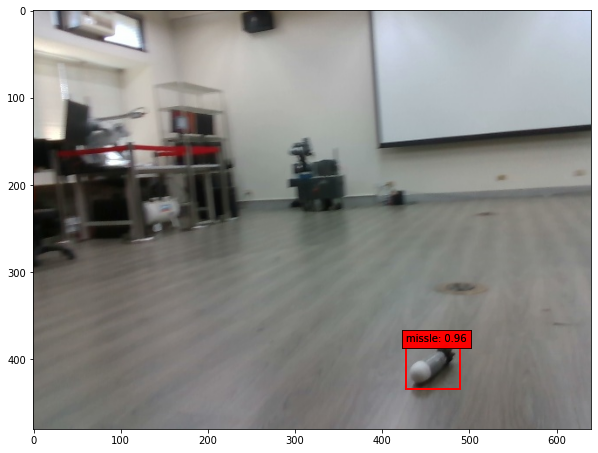

In [ ]:
img_list = []

for line in open(osp.join(test_file)):
    img_list.append(line.strip())

img_id = random.randint(0, len(img_list)-1)
# print(img_id)
#img_path = IMAGE_ROOT + '/' + img_list[img_id]
img_path = IMAGE_ROOT + '/' + img_list[img_id] + '.jpg'


image = cv2.imread(img_path)

# scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)


rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# View the sampled input image before transform
plt.figure(figsize=(10,10))


x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
x = torch.from_numpy(x).permute(2, 0, 1)

xx = Variable(x.unsqueeze(0))# wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = vaild_net(xx)
currentAxis = plt.gca()
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
detections = y.data # torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
objs = []
accuracy = [0,0,0,0,0]
for i in range(detections.size(1)): # detections.size(1) --> class size
    for j in range(5): # each class choose top 5 predictions
        if detections[0, i, j, 0].cpu().numpy() > 0.5:
            score = detections[0, i, j, 0]
            pt = (detections[0, i, j,1:]*scale).cpu().numpy()
            objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i, score])


    color_BBX = (255, 255, 0)
    color_TEXT = (255, 0, 0)
    colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()

    for i, obj in enumerate(objs):
        coords = (obj[0], obj[1]), obj[2], obj[3]
        print(obj[0], obj[0]+obj[2],obj[1],obj[1]+obj[3])
        display_txt = '%s: %.2f'%(label[obj[4]], obj[5])
        # print(label[obj[4]])
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[i], linewidth=2))
        currentAxis.text(obj[0], obj[1], display_txt, bbox={'facecolor':colors[i], 'alpha':0.5})

plt.imshow(rgb_image)